# Facial Recog Library Test

Install Guide:
https://github.com/ageitgey/face_recognition

In [75]:
from PIL import Image, ImageDraw
import mediapipe as mp
import face_recognition
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
import scipy.sparse as sparse
import scipy.sparse.linalg as sl
from scipy.sparse.linalg import spsolve
import scipy as sp

### Facial Landmarks Detection Using MediaPipe

In [43]:
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)

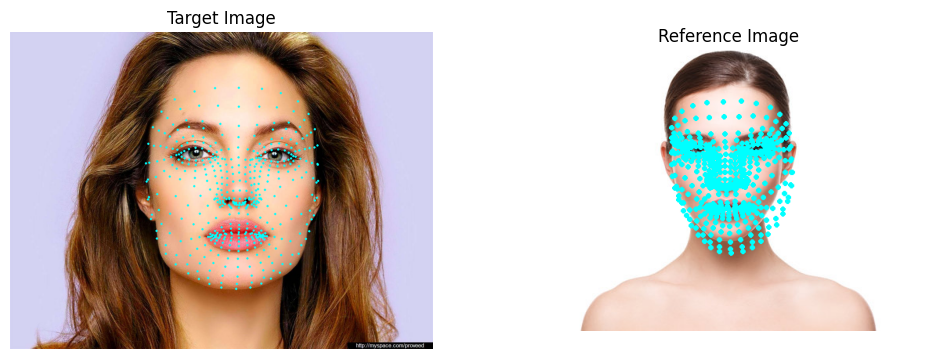

In [44]:
trgt_img_path = r"Facial_Recog_test/face_target.jpg"
ref_img_path = r"Facial_Recog_test/face_ref.jpg"

trgt_img = cv2.imread(trgt_img_path)
trgt_img = cv2.cvtColor(trgt_img, cv2.COLOR_BGR2RGB)

ref_img = cv2.imread(ref_img_path)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

trgt_img_res = faceMesh.process(trgt_img)
ref_img_res = faceMesh.process(ref_img)

trgt_img_landmarks = []
ref_img_landmarks = []

if trgt_img_res.multi_face_landmarks:
    for face_landmarks in trgt_img_res.multi_face_landmarks:
        trgt_img_landmarks.append(face_landmarks.landmark)

if ref_img_res.multi_face_landmarks:
    for face_landmarks in ref_img_res.multi_face_landmarks:
        ref_img_landmarks.append(face_landmarks.landmark)

trgt_img_landmarks_np = np.empty((468, 2), dtype=np.float32)
ref_img_landmarks_np = np.empty((468, 2), dtype=np.float32)

for i, landmark in enumerate(trgt_img_landmarks[0]):
    trgt_img_landmarks_np[i] = np.array([landmark.x, landmark.y])

for i, landmark in enumerate(ref_img_landmarks[0]):
    ref_img_landmarks_np[i] = np.array([landmark.x, landmark.y])

trgt_img_h, trgt_img_w, _ = trgt_img.shape
ref_img_h, ref_img_w, _ = ref_img.shape

# normalize landmark locations
trgt_img_landmarks_np[:, 0] = (trgt_img_landmarks_np[:, 0] * trgt_img_w).astype(np.int32)
trgt_img_landmarks_np[:, 1] = (trgt_img_landmarks_np[:, 1] * trgt_img_h).astype(np.int32)

ref_img_landmarks_np[:, 0] = (ref_img_landmarks_np[:, 0] * ref_img_w).astype(np.int32)
ref_img_landmarks_np[:, 1] = (ref_img_landmarks_np[:, 1] * ref_img_h).astype(np.int32)

# draw landmarks over the face
pil_image1 = Image.fromarray(trgt_img)
pil_image2 = Image.fromarray(ref_img)

d1 = ImageDraw.Draw(pil_image1)
d2 = ImageDraw.Draw(pil_image2)

for point in trgt_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d1.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

for point in ref_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d2.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(pil_image1)
plt.axis('off')
plt.title('Target Image')
plt.subplot(122)
plt.imshow(pil_image2)
plt.axis('off')
plt.title('Reference Image')
plt.show()

### Facial Landmarks Detection Using Dlib

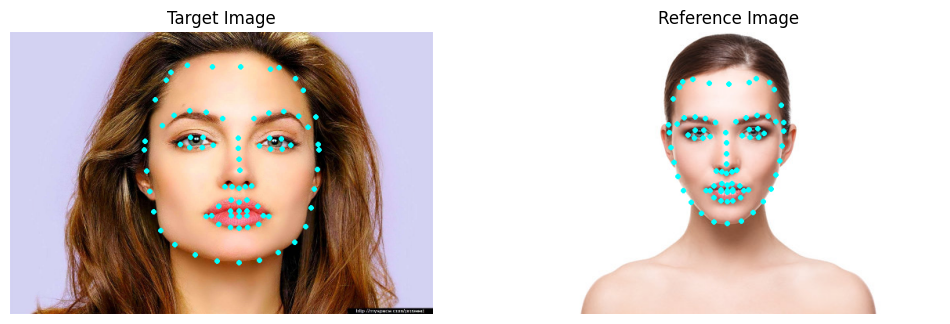

In [97]:
predictor_path = r"Facial Landmark Detection Models/shape_predictor_81_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

trgt_img = cv2.imread("Facial_Recog_test/face_target.jpg")
ref_img = cv2.imread("Facial_Recog_test/face_ref.jpg")

trgt_img = cv2.cvtColor(trgt_img, cv2.COLOR_BGR2RGB)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

trgt_img = cv2.resize(trgt_img, (ref_img.shape[1], ref_img.shape[0]))

trgt_img_gray = cv2.cvtColor(trgt_img, cv2.COLOR_BGR2GRAY)
ref_img_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY)

trgt_img_rects = detector(trgt_img, 0)
ref_img_rects = detector(ref_img, 0)

trgt_img_landmarks_np = np.empty((0,2), dtype=int)
ref_img_landmarks_np = np.empty((0,2), dtype=int)

for trgt_img_rect, ref_img_rect in zip(trgt_img_rects, ref_img_rects):
    trgt_img_shape = predictor(trgt_img_gray, trgt_img_rect)
    ref_img_shape = predictor(ref_img_gray, ref_img_rect)

    for i in range(81):
        trgt_img_landmarks_np = np.append(trgt_img_landmarks_np, [[trgt_img_shape.part(i).x, trgt_img_shape.part(i).y]], axis=0)
        ref_img_landmarks_np = np.append(ref_img_landmarks_np, [[ref_img_shape.part(i).x, ref_img_shape.part(i).y]], axis=0)

# draw landmarks over the face
pil_image1 = Image.fromarray(trgt_img)
pil_image2 = Image.fromarray(ref_img)

d1 = ImageDraw.Draw(pil_image1)
d2 = ImageDraw.Draw(pil_image2)

for point in trgt_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d1.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

for point in ref_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d2.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(pil_image1)
plt.axis('off')
plt.title('Target Image')
plt.subplot(122)
plt.imshow(pil_image2)
plt.axis('off')
plt.title('Reference Image')
plt.show()

### Facial Landmarks Detection Using Facial Recognition Library

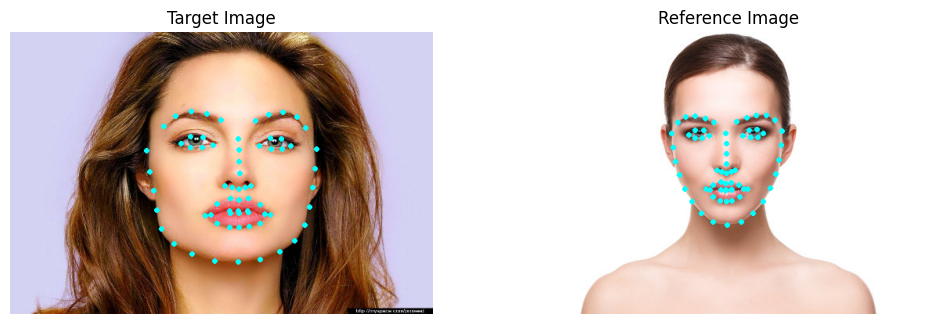

In [46]:
# get the face landmarks of both faces
trgt_img = face_recognition.load_image_file("Facial_Recog_test/face_target.jpg")
ref_img = face_recognition.load_image_file("Facial_Recog_test/face_ref.jpg")

trgt_img = cv2.resize(trgt_img, (ref_img.shape[1], ref_img.shape[0]))

trgt_img_landmarks = face_recognition.face_landmarks(trgt_img)
ref_img_landmarks = face_recognition.face_landmarks(ref_img)

trgt_img_landmarks_np = np.empty((0,2), dtype=int)
ref_img_landmarks_np = np.empty((0,2), dtype=int)

for face_landmarks in trgt_img_landmarks:
    for facial_feature in face_landmarks.keys():
        trgt_img_landmarks_np = np.append(trgt_img_landmarks_np, face_landmarks[facial_feature], axis=0)

for face_landmarks in ref_img_landmarks:
    for facial_feature in face_landmarks.keys():
        ref_img_landmarks_np = np.append(ref_img_landmarks_np, face_landmarks[facial_feature], axis=0)

# draw landmarks over the face
pil_image1 = Image.fromarray(trgt_img)
pil_image2 = Image.fromarray(ref_img)

d1 = ImageDraw.Draw(pil_image1)
d2 = ImageDraw.Draw(pil_image2)

for point in trgt_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d1.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

for point in ref_img_landmarks_np:
    x1, y1 = point[0] - 3, point[1] - 3
    x2, y2 = point[0] + 3, point[1] + 3
    d2.ellipse((x1, y1, x2, y2), fill=(0, 255, 255), width=2)

plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(pil_image1)
plt.axis('off')
plt.title('Target Image')
plt.subplot(122)
plt.imshow(pil_image2)
plt.axis('off')
plt.title('Reference Image')
plt.show()


### Facial Warping

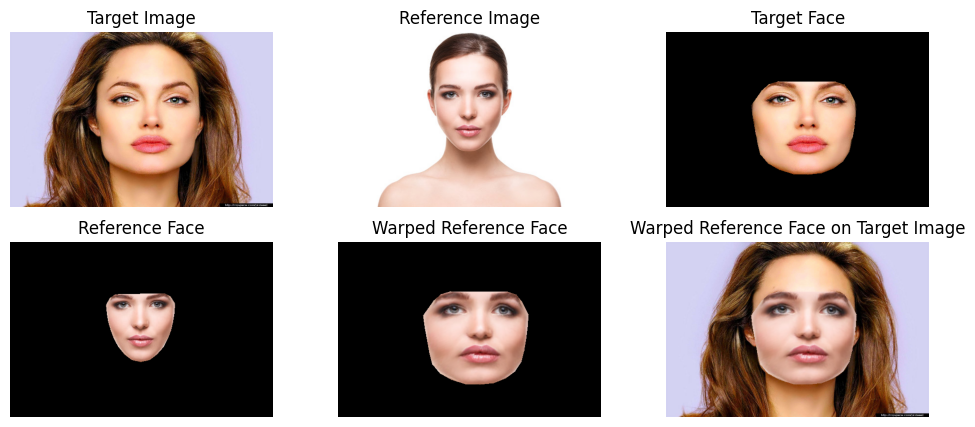

In [47]:
transform = PiecewiseAffineTransform()
transform.estimate(trgt_img_landmarks_np, ref_img_landmarks_np)

ref_face_hull = cv2.convexHull(ref_img_landmarks_np).astype(np.int32)
ref_face_mask = np.zeros(ref_img.shape[:2], dtype=np.float32)
cv2.fillConvexPoly(ref_face_mask, ref_face_hull, 1)
ref_face_mask = ref_face_mask > 0
ref_face = np.zeros_like(ref_img)
ref_face[ref_face_mask] = ref_img[ref_face_mask]

warped_ref_face = (warp(ref_img, transform, output_shape=trgt_img.shape) * 255).astype(np.uint8)

mask = (warped_ref_face != 0).all(axis=2)

warped_ref_face_on_trgt = warped_ref_face * mask[:,:,None] + trgt_img * ~mask[:,:,None]
warped_ref_face_on_trgt = warped_ref_face_on_trgt.astype(np.uint8)

trgt_face = trgt_img * mask[:,:,None]

plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(trgt_img)
plt.axis('off')
plt.title("Target Image")
plt.subplot(232)
plt.imshow(ref_img)
plt.axis('off')
plt.title("Reference Image")
plt.subplot(233)
plt.imshow(trgt_face)
plt.axis('off')
plt.title("Target Face")
plt.subplot(234)
plt.imshow(ref_face)
plt.axis('off')
plt.title("Reference Face")
plt.subplot(235)
plt.imshow(warped_ref_face)
plt.axis('off')
plt.title("Warped Reference Face")
plt.subplot(236)
plt.imshow(warped_ref_face_on_trgt)
plt.axis('off')
plt.title("Warped Reference Face on Target Image")
plt.show()



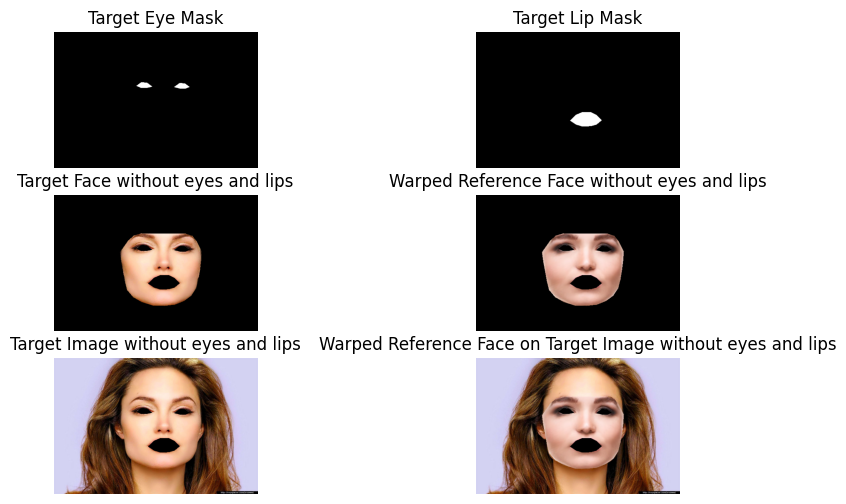

In [48]:
# remove eyes and lips from the target face by creating a mask of the eye region
trgt_left_eye = cv2.convexHull(np.array(trgt_img_landmarks[0]['left_eye']))
trgt_right_eye = cv2.convexHull(np.array(trgt_img_landmarks[0]['right_eye']))
trgt_top_lip = cv2.convexHull(np.array(trgt_img_landmarks[0]['top_lip']))
trgt_bottom_lip = cv2.convexHull(np.array(trgt_img_landmarks[0]['bottom_lip']))

trgt_left_eye_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_right_eye_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_top_lip_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_bottom_lip_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)

cv2.fillConvexPoly(trgt_left_eye_mask, trgt_left_eye, 1)
cv2.fillConvexPoly(trgt_right_eye_mask, trgt_right_eye, 1)
cv2.fillConvexPoly(trgt_top_lip_mask, trgt_top_lip, 1)
cv2.fillConvexPoly(trgt_bottom_lip_mask, trgt_bottom_lip, 1)

trgt_eye_mask = trgt_left_eye_mask + trgt_right_eye_mask
trgt_lip_mask = trgt_top_lip_mask + trgt_bottom_lip_mask
trgt_lip_mask[trgt_lip_mask > 1] = 1

# combine the masks
eye_lip_mask = trgt_eye_mask + trgt_lip_mask
eye_lip_mask[eye_lip_mask > 1] = 1

# remove the eyes and lips from the target face and the warped reference face
trgt_face_without_eye_lip = trgt_face * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)
warped_ref_face_without_eye_lip = warped_ref_face * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)

trgt_img_without_eye_lip = trgt_img * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)
warped_ref_face_on_trgt_without_eye_lip = warped_ref_face_on_trgt * (1 - eye_lip_mask[:,:,None]).astype(np.uint8)

plt.figure(figsize=(10,6))
plt.subplot(321)
plt.imshow(trgt_eye_mask, cmap='gray')
plt.axis('off')
plt.title("Target Eye Mask")
plt.subplot(322)
plt.imshow(trgt_lip_mask, cmap='gray')
plt.axis('off')
plt.title("Target Lip Mask")
plt.subplot(323)
plt.imshow(trgt_face_without_eye_lip)
plt.axis('off')
plt.title("Target Face without eyes and lips")
plt.subplot(324)
plt.imshow(warped_ref_face_without_eye_lip)
plt.axis('off')
plt.title("Warped Reference Face without eyes and lips")
plt.subplot(325)
plt.imshow(trgt_img_without_eye_lip)
plt.axis('off')
plt.title("Target Image without eyes and lips")
plt.subplot(326)
plt.imshow(warped_ref_face_on_trgt_without_eye_lip)
plt.axis('off')
plt.title("Warped Reference Face on Target Image without eyes and lips")
plt.show()


# Hair-Forehead Edge Detection

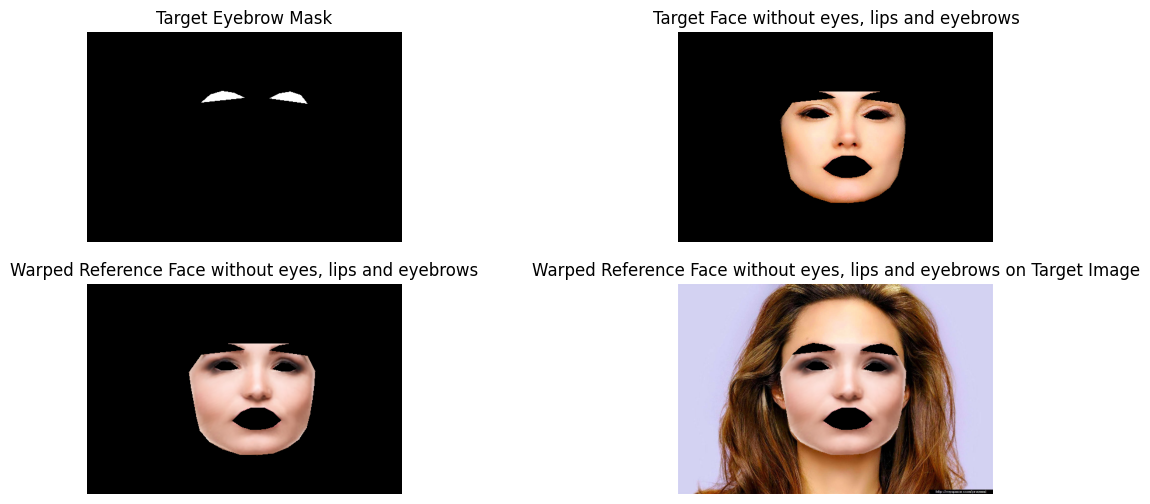

In [50]:
# remove eyebrows from the target face by creating a mask of the eyebrow region
trgt_left_eyebrow = cv2.convexHull(np.array(trgt_img_landmarks[0]['left_eyebrow']))
trgt_right_eyebrow = cv2.convexHull(np.array(trgt_img_landmarks[0]['right_eyebrow']))

trgt_left_eyebrow_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)
trgt_right_eyebrow_mask = np.zeros(trgt_img.shape[:2], dtype=np.float32)

cv2.fillConvexPoly(trgt_left_eyebrow_mask, trgt_left_eyebrow, 1)
cv2.fillConvexPoly(trgt_right_eyebrow_mask, trgt_right_eyebrow, 1)

trgt_eyebrow_mask = trgt_left_eyebrow_mask + trgt_right_eyebrow_mask
trgt_eyebrow_mask[trgt_eyebrow_mask > 1] = 1

# remove the eyebrows from the target face and the warped reference face
trgt_face_without_eye_lip_eyebrow = trgt_face_without_eye_lip * (1 - trgt_eyebrow_mask[:,:,None]).astype(np.uint8)
warped_ref_face_without_eye_lip_eyebrow = warped_ref_face_without_eye_lip * (1 - trgt_eyebrow_mask[:,:,None]).astype(np.uint8)

trgt_img_without_eye_lip_eyebrow = trgt_img_without_eye_lip * (1 - trgt_eyebrow_mask[:,:,None]).astype(np.uint8)
warped_ref_face_on_trgt_without_eye_lip_eyebrow = warped_ref_face_on_trgt_without_eye_lip * (1 - trgt_eyebrow_mask[:,:,None]).astype(np.uint8)

plt.figure(figsize=(14,6))
plt.subplot(221)
plt.imshow(trgt_eyebrow_mask, cmap='gray')
plt.axis('off')
plt.title("Target Eyebrow Mask")
plt.subplot(222)
plt.imshow(trgt_face_without_eye_lip_eyebrow)
plt.axis('off')
plt.title("Target Face without eyes, lips and eyebrows")
plt.subplot(223)
plt.imshow(warped_ref_face_without_eye_lip_eyebrow)
plt.axis('off')
plt.title("Warped Reference Face without eyes, lips and eyebrows")
plt.subplot(224)
plt.imshow(warped_ref_face_on_trgt_without_eye_lip_eyebrow)
plt.axis('off')
plt.title("Warped Reference Face without eyes, lips and eyebrows on Target Image")
plt.show()

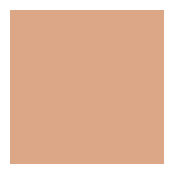

In [51]:
# average skin color of the target face without eyes, lips and eyebrows
trgt_face_skin_color = np.mean(trgt_face_without_eye_lip_eyebrow[face_mask], axis=0)

# show the skin colour in a rectangle
skin = np.ones((20, 20, 3), dtype=np.uint8)

for i in range(3):
    skin[:,:,i] *= trgt_face_skin_color[i].astype(np.uint8)

plt.figure(figsize=(2,2))
plt.imshow(skin)
plt.axis('off')
plt.show()

### Linear Color Scaling of Reference Face to Match Target Face

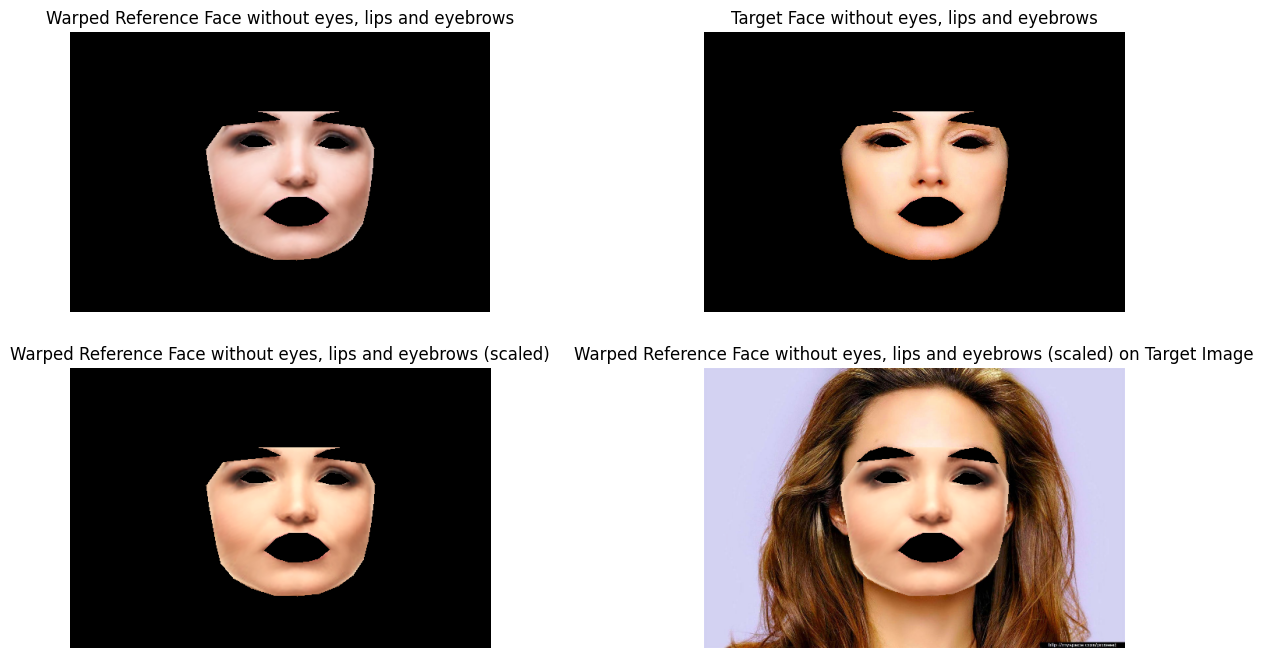

In [154]:
def linearColorScaling(warped_ref_face_without_eye_lip_eyebrow, trgt_face_without_eye_lip_eyebrow, face_mask):

    # scale the warped reference face to match the color of the target face. adjust the scaling factor to get the best result
    warped_ref_face_without_eye_lip_eyebrow_scaled = np.empty_like(warped_ref_face_without_eye_lip_eyebrow, dtype=np.float64)

    scaling_factors = np.linspace(0.6, 1.6, 200)

    for i in range(3):
        min_error = np.inf
        for scaling_factor in scaling_factors:
            a = warped_ref_face_without_eye_lip[:,:,i].flatten().astype(np.float64)
            b = trgt_face_without_eye_lip[:,:,i].flatten().astype(np.float64)
            a *= scaling_factor
            #a = np.clip(a, 0, 255)
            error = np.sum((a - b) ** 2)
            if error < min_error:
                min_error = error
                best_scaling_factor = scaling_factor
        
        warped_ref_face_without_eye_lip_eyebrow_scaled[:,:,i] = warped_ref_face_without_eye_lip_eyebrow[:,:,i].astype(np.float64) * best_scaling_factor
        warped_ref_face_without_eye_lip_eyebrow_scaled[:,:,i] = np.clip(warped_ref_face_without_eye_lip_eyebrow_scaled[:,:,i], 0, 255)

        #print("Scaling Factor for channel {} : {}".format(i, best_scaling_factor))

    warped_ref_face_without_eye_lip_eyebrow_scaled[~face_mask] = 0
    
    return warped_ref_face_without_eye_lip_eyebrow_scaled.astype(np.uint8)

face_mask = mask - eye_lip_mask - trgt_eyebrow_mask
face_mask[face_mask < 0] = 0
face_mask = face_mask.astype(bool)

warped_ref_face_without_eye_lip_eyebrow_scaled = linearColorScaling(warped_ref_face_without_eye_lip_eyebrow, trgt_face_without_eye_lip_eyebrow, face_mask)

warped_ref_face_without_eye_lip_eyebrow_scaled_on_trgt = warped_ref_face_without_eye_lip_eyebrow_scaled * face_mask[:,:,None] + trgt_img_without_eye_lip_eyebrow * ~face_mask[:,:,None]

# show the original and scaled warped reference face
plt.figure(figsize=(15,8))
plt.subplot(221)
plt.imshow(warped_ref_face_without_eye_lip_eyebrow)
plt.axis('off')
plt.title("Warped Reference Face without eyes, lips and eyebrows")
plt.subplot(222)
plt.imshow(trgt_face_without_eye_lip_eyebrow)
plt.axis('off')
plt.title("Target Face without eyes, lips and eyebrows")
plt.subplot(223)
plt.imshow(warped_ref_face_without_eye_lip_eyebrow_scaled)
plt.axis('off')
plt.title("Warped Reference Face without eyes, lips and eyebrows (scaled)")
plt.subplot(224)
plt.imshow(warped_ref_face_without_eye_lip_eyebrow_scaled_on_trgt)
plt.axis('off')
plt.title("Warped Reference Face without eyes, lips and eyebrows (scaled) on Target Image")
plt.show()


### Otsu's Method

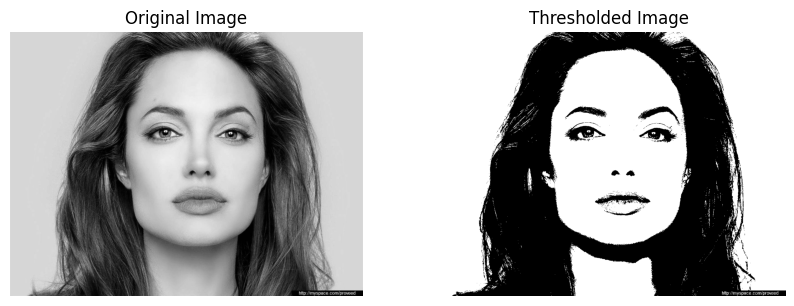

In [57]:

def compute_otsu_criteria(im, th):
    """Otsu's method to compute criteria."""
    # create the thresholded image
    thresholded_im = np.zeros(im.shape)
    thresholded_im[im >= th] = 1

    # compute weights
    nb_pixels = im.size
    nb_pixels1 = np.count_nonzero(thresholded_im)
    weight1 = nb_pixels1 / nb_pixels
    weight0 = 1 - weight1

    # if one of the classes is empty, eg all pixels are below or above the threshold, that threshold will not be considered
    # in the search for the best threshold
    if weight1 == 0 or weight0 == 0:
        return np.inf

    # find all pixels belonging to each class
    val_pixels1 = im[thresholded_im == 1]
    val_pixels0 = im[thresholded_im == 0]

    # compute variance of these classes
    var1 = np.var(val_pixels1) if len(val_pixels1) > 0 else 0
    var0 = np.var(val_pixels0) if len(val_pixels0) > 0 else 0

    return weight0 * var0 + weight1 * var1

im = cv2.imread("Facial_Recog_test/face_target.jpg", cv2.IMREAD_GRAYSCALE)
# For testing purposes, one can use for example im = np.random.randint(0,255, size = (50,50))

# testing all thresholds from 0 to the maximum of the image
threshold_range = range(np.max(im)+1)
criterias = [compute_otsu_criteria(im, th) for th in threshold_range]

# best threshold is the one minimizing the Otsu criteria
best_threshold = threshold_range[np.argmin(criterias)]

# create the thresholded image
thresholded_im = np.zeros(im.shape)
thresholded_im[im >= best_threshold] = 1

# show the results
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.axis('off')
plt.title("Original Image")
plt.subplot(122)
plt.imshow(thresholded_im, cmap='gray')
plt.axis('off')
plt.title("Thresholded Image")
plt.show()

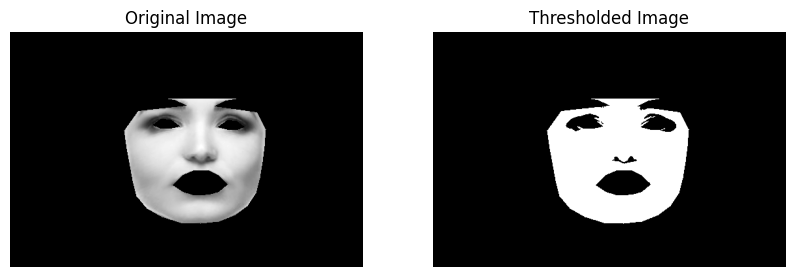

In [58]:
## apply Otsu's method to the warped reference face without eyes, lips and eyebrows
#warped_ref_face_without_eye_lip_eyebrow_gray = cv2.cvtColor(warped_ref_face_without_eye_lip_eyebrow, cv2.COLOR_RGB2GRAY)
#warped_ref_face_without_eye_lip_eyebrow_gray = warped_ref_face_without_eye_lip_eyebrow_gray.astype(np.uint8)
#
#threshold_range = range(np.max(warped_ref_face_without_eye_lip_eyebrow_gray)+1)
#criterias = [compute_otsu_criteria(warped_ref_face_without_eye_lip_eyebrow_gray, th) for th in threshold_range]
#
#best_threshold = threshold_range[np.argmin(criterias)]
#
#warped_ref_face_without_eye_lip_eyebrow_gray_thresholded = np.zeros(warped_ref_face_without_eye_lip_eyebrow_gray.shape)
#
#warped_ref_face_without_eye_lip_eyebrow_gray_thresholded[warped_ref_face_without_eye_lip_eyebrow_gray >= best_threshold] = 1
#
## show the results
#plt.figure(figsize=(10,5))
#plt.subplot(121)
#plt.imshow(warped_ref_face_without_eye_lip_eyebrow_gray, cmap='gray')
#plt.axis('off')
#plt.title("Original Image")
#plt.subplot(122)
#plt.imshow(warped_ref_face_without_eye_lip_eyebrow_gray_thresholded, cmap='gray')
#plt.axis('off')
#plt.title("Thresholded Image")
#plt.show()


### Layer Decomposition

The face layers are converted to CIE Lab colour space. The Lightness (highlight) layer $L$ is given by,
$$
L = s + d
$$
where $s$ is the large scale layer and $d$ is the detail layer.
$s$ is obtained from $L$ by applying a Weighted Least Squares (WLS) filter. The detail layer $d$ is obtained by subtracting $s$ from $L$.

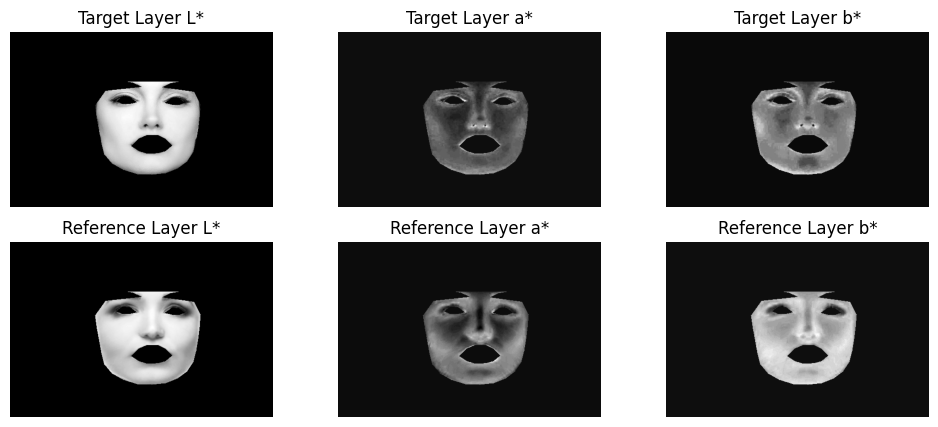

In [63]:
# renaming layers for better readability
trgt_layer = trgt_face_without_eye_lip_eyebrow
ref_layer = warped_ref_face_without_eye_lip_eyebrow_scaled

# convert to CIE L*a*b* colorspace
trgt_layer_lab = cv2.cvtColor(trgt_layer, cv2.COLOR_RGB2LAB)
ref_layer_lab = cv2.cvtColor(ref_layer, cv2.COLOR_RGB2LAB)

trgt_L = trgt_layer_lab[:,:,0]
ref_L = ref_layer_lab[:,:,0]

# show the layers in the CIE L*a*b* colorspace
plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(trgt_layer_lab[:,:,0], cmap='gray')
plt.axis('off')
plt.title("Target Layer L*")
plt.subplot(232)
plt.imshow(trgt_layer_lab[:,:,1], cmap='gray')
plt.axis('off')
plt.title("Target Layer a*")
plt.subplot(233)
plt.imshow(trgt_layer_lab[:,:,2], cmap='gray')
plt.axis('off')
plt.title("Target Layer b*")
plt.subplot(234)
plt.imshow(ref_layer_lab[:,:,0], cmap='gray')
plt.axis('off')
plt.title("Reference Layer L*")
plt.subplot(235)
plt.imshow(ref_layer_lab[:,:,1], cmap='gray')
plt.axis('off')
plt.title("Reference Layer a*")
plt.subplot(236)
plt.imshow(ref_layer_lab[:,:,2], cmap='gray')
plt.axis('off')
plt.title("Reference Layer b*")
plt.show()


In [83]:
def weightedLeastSquaresFilter(L, lambda_=0.35, alpha=1.2):
    '''
    Weighted Least Squares Filter on highlight layer L
    '''
    # Get log-luminance
    

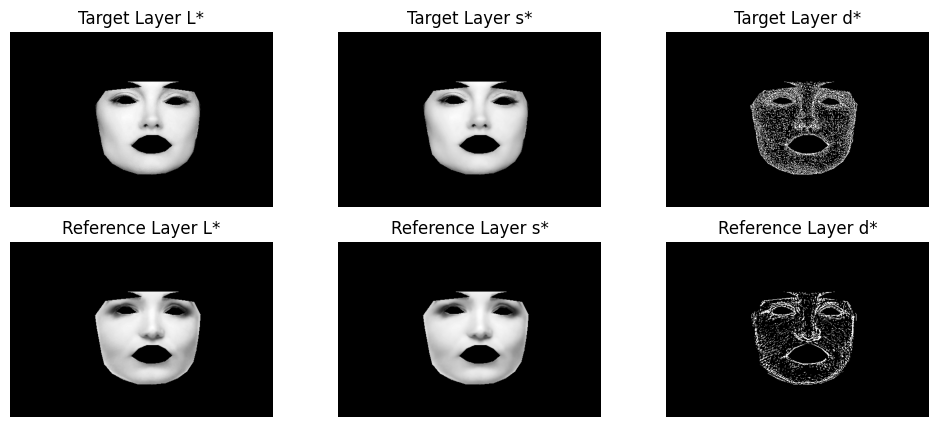

In [245]:
trgt_layer = trgt_face_without_eye_lip_eyebrow
ref_layer = warped_ref_face_without_eye_lip_eyebrow_scaled

trgt_layer_lab = cv2.cvtColor(trgt_layer, cv2.COLOR_RGB2LAB)
ref_layer_lab = cv2.cvtColor(ref_layer, cv2.COLOR_RGB2LAB)

trgt_L = trgt_layer_lab[:,:,0]
ref_L = ref_layer_lab[:,:,0]

# for now use bilateral filter instead of weighted least squares filter
trgt_s = cv2.bilateralFilter(trgt_L, 20, 13, 1)
ref_s = cv2.bilateralFilter(ref_L, 20, 13, 1)

trgt_d = trgt_L - trgt_s
ref_d = ref_L - ref_s

# show L, s and d layers
plt.figure(figsize=(12,5))
plt.subplot(231)
plt.imshow(trgt_L, cmap='gray')
plt.axis('off')
plt.title("Target Layer L*")
plt.subplot(232)
plt.imshow(trgt_s, cmap='gray')
plt.axis('off')
plt.title("Target Layer s*")
plt.subplot(233)
plt.imshow(trgt_d, cmap='gray')
plt.axis('off')
plt.title("Target Layer d*")
plt.subplot(234)
plt.imshow(ref_L, cmap='gray')
plt.axis('off')
plt.title("Reference Layer L*")
plt.subplot(235)
plt.imshow(ref_s, cmap='gray')
plt.axis('off')
plt.title("Reference Layer s*")
plt.subplot(236)
plt.imshow(ref_d, cmap='gray')
plt.axis('off')
plt.title("Reference Layer d*")
plt.show()



### Highlight Transfer/ Large Scale Layer Transfer

seamlessClone in OpenCV uses Poisson Blending to blend two layers. The gradient of the source layer is matched to the gradient of the target layer.

In [226]:
import scipy.sparse
from scipy.sparse.linalg import spsolve

def laplacian_matrix(n, m):
    """Generate the Poisson matrix. 

    Refer to: 
    https://en.wikipedia.org/wiki/Discrete_Poisson_equation

    Note: it's the transpose of the wiki's matrix 
    """
    mat_D = scipy.sparse.lil_matrix((m, m))
    mat_D.setdiag(-1, -1)
    mat_D.setdiag(4)
    mat_D.setdiag(-1, 1)
        
    mat_A = scipy.sparse.block_diag([mat_D] * n).tolil()
    
    mat_A.setdiag(-1, 1*m)
    mat_A.setdiag(-1, -1*m)
    
    return mat_A

def poisson_blend(source, target, mask):
    """The poisson blending function. 

    Refer to: 
    Perez et. al., "Poisson Image Editing", 2003.
    """

    h, w = mask.shape
    y_range, x_range = h, w
    mask[mask > 0] = 1
    
    mat_A = laplacian_matrix(y_range, x_range)

    # for \Delta g
    laplacian = mat_A.tocsc()

    # set the region outside the mask to identity    
    for y in range(1, y_range - 1):
        for x in range(1, x_range - 1):
            if mask[y, x] == 0:
                k = x + y * x_range
                mat_A[k, k] = 1
                mat_A[k, k + 1] = 0
                mat_A[k, k - 1] = 0
                mat_A[k, k + x_range] = 0
                mat_A[k, k - x_range] = 0

    mat_A = mat_A.tocsc()

    mask_flat = mask.flatten()    
    source_flat = source.flatten()
    target_flat = target.flatten()        
   
    alpha = 1
    mat_b = laplacian.dot(source_flat)*alpha

    mat_b[mask_flat==0] = target_flat[mask_flat==0]
    
    x = spsolve(mat_A, mat_b)
    x = x.reshape((y_range, x_range))
    x[x > 255] = 255
    x[x < 0] = 0
    x = x.astype('uint8')

    return x



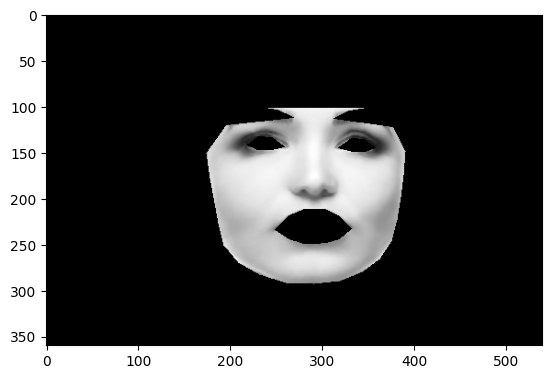

In [246]:
final_s = poisson_blend(ref_s, trgt_s, face_mask.astype(np.uint8))
plt.imshow(final_s, cmap='gray')